<a href="https://colab.research.google.com/github/pritamdey/ShortestPath-BNW22/blob/main/Full_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bernstein, Nanongkai, and Wulff-Nilsen Method

In [1]:
import networkx as nx
import random
import math
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
## Sample Graph
G = nx.fast_gnp_random_graph(20, .4, directed = True)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(-3,10)

## Low-Diameter Decomposition

In [3]:
def ballout(G, v, R):
    ball_out = set([v])
    boundary = set()
    visited = {v}
    queue = [(v, 0)]
    while queue:
        node, dist = queue.pop(0)
        if dist <= R:
            for neighbor in G.successors(node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, dist + G[node][neighbor]['weight']))
                    if dist + G[node][neighbor]['weight'] <= R:
                        ball_out.add(neighbor)
                        boundary.add((node, neighbor))
        else:
            break
    return ball_out, boundary

def ballin(G, v, R):
    ball_in = set([v]) 
    boundary = set()    
    visited = set()
    queue = [(v, 0)]
    while queue:
        u, dist = queue.pop(0)    
        if dist <= R:       
          if u not in visited:
            visited.add(u)  
            if dist > 0:
                ball_in.add(u)
            for neighbor in G.predecessors(u):
                if neighbor not in visited:
                    queue.append((neighbor, dist + G[neighbor][u]['weight']))
                    if dist + G[neighbor][u]['weight'] <= R:
                        boundary.add((neighbor, u))
            
    return ball_in, boundary

In [4]:
## LDD
from collections import deque

def LDD(G, D):
  # Set global variable n to number of vertices in G
  n = G.number_of_nodes()
  # Copy G to G0 and initialize empty set Erem for remaining edges
  G0 = G.copy()
  E_rem = set()

  if n <= 1:
    return E_rem
  # Phase 1: mark vertices as light, out-light, or heavy
  c = 3
  k = int(c * math.log(n))
  S = set(random.sample(list(G.nodes), k))

  for s_i in S:
    s_i_ballout, _ = ballout(G, s_i, D/4)
    s_i_ballin = ballin(G, s_i, D/4)

  lightNodes = set([])
  for v in G.nodes():
    v_ballin, _ = ballin(G, v, D/4)
    if len(S.intersection(v_ballin)) <= .6*k:
      lightNodes.add(v)
      G.nodes[v]['mark'] = 'in-light'
    else:
      v_ballout, _ = ballout(G, v, D/4)
      if len(S.intersection(v_ballout)) <= .6*k:
        lightNodes.add(v)
        G.nodes[v]['mark'] = 'out-light'
      else:
        G.nodes[v]['mark'] = 'heavy'
  # Phase 2: carve out balls until no light vertices remain
  p = min(1, 80* math.log2(n)/D)
  if len(lightNodes) > 0:
    while G != None and len(lightNodes.intersection(G.nodes())) > 0:
      v = random.sample(list(lightNodes.intersection(G.nodes())), 1)[0]
      R_v = np.random.geometric(p, 1)
      ball_star, ball_star_boundary = None, None
      if G.nodes[v]['mark'] == 'in-light':
        ball_star, ball_star_boundary = ballin(G, v, R_v)
      if G.nodes[v]['mark'] == 'out-light':
        ball_star, ball_star_boundary = ballout(G, v, R_v)
      E_boundary = ball_star_boundary
      if R_v > D/4 or len(ball_star) > .7*n:
        E_rem = G.edges()
        return E_rem
      E_recurse = LDD(G.subgraph(ball_star).copy(), D)
      E_rem = E_rem.union(E_boundary.union(E_recurse))
      G = G.remove_nodes_from(ball_star)
  
  ## Clean up

  v = random.sample(list(G0.nodes), 1)[0]
  v_ballin, _ = ballin(G0, v, D/2)
  v_ballout, _ = ballout(G0, v, D/2)

  if G != None and (not v_ballin.issuperset(G.nodes) or not v_ballout.issuperset(G.nodes)):
    E_rem = G.edges
    return E_rem

  return E_rem

## ElimNeg

In [5]:
from queue import PriorityQueue
def ElimNeg(G):
  s = random.sample(list(G.nodes()), 1)[0]
  d = {v: 99999 for v in G.nodes()}
  d[s] = 0
  Q = {}
  Q[s] = d[s]
  marked = {v: False for v in G.nodes()}
  iter = 0
  while bool(Q):
    if iter > 50:
      return "Elim Neg Did not Terminate"
    # Dijkstra Phase
    while bool(Q):
      v = min(Q, key=Q.get)
      Q.pop(v, None)
      marked[v] = True
      for x in G[v]:
        if G[v][x]['weight'] >= 0:
          if d[v] + G[v][x]['weight'] < d[x]:
            d[x] = d[v] + G[v][x]['weight']
            Q[x] = d[x]
    # Bellman-Ford Phase
    for v in marked.keys():
      if marked[v]:
        for x in G[v]:
          if G[v][x]['weight'] < 0:
            if d[v] + G[v][x]['weight'] < d[x]:
              d[x] = d[v] + G[v][x]['weight']
              Q[x] = d[x]
        marked[v] = False
    iter = iter + 1
  return d

## FixDAGEdges

In [6]:
def FixDAGEdges(G, P, n):
    k = len(P)
    # Line 1: Re-order P = <V0, V1, ..., V_k-1> in topological order
    G_condensed = nx.condensation(G, P)
    order = nx.topological_sort(G_condensed)
    P = [P[i] for i in order] 
    
    # Line 2: mu_j = min negative edge weight entering Vj, or 0 if no such edge exists
    mu = [0] * k
    for u,v in G.edges():
        for j, Vj in enumerate(P):
            if (u not in Vj) and (v in Vj) and G[u][v]['weight'] < mu[j]:
                mu[j] = G[u][v]['weight']

    # Lines 3-6
    phi = [0] * n
    M = np.cumsum(mu)
    for j, Vj in enumerate(P):
        for v in Vj:
            phi[v] = M[j]
    # Line 7
    return phi

## Scaledown

In [7]:
## Scaledown

def ScaleDown(G, delta, B, n):
  phi2 = [0] * n
  if len(G.nodes()) == 0:
    return phi2
  G_B = G.copy()
  for u,v in G_B.edges():
    G_B[u][v]['weight'] = max(0, G[u][v]['weight']+B)
  if delta > 2:
    d = delta/2
    
    # Phase 0: Decompose V to SCCs V1, V2, . . . with weak diameter dB in G
    E_rem = LDD(G_B, d*B)
    G_B_cut_E_rem = G_B.copy()
    G_B_cut_E_rem.remove_edges_from(E_rem)
    V = list(G_B_cut_E_rem.nodes())
    V_rem = set([v for (_, v) in E_rem])
    SCCs = list(nx.strongly_connected_components(G_B_cut_E_rem))
    H = nx.DiGraph()
    for SCC in SCCs:
      for u in SCC:
        for v in G.successors(u):
          if v in SCC:
            H.add_edge(u,v, weight = G[u][v]['weight'])
    phi1 = ScaleDown(H, d, B, n)
    G_B_phi1 = G_B.copy()
    for u,v in G_B.edges():
      G_B_phi1[u][v]['weight'] = G_B[u][v]['weight'] + phi1[u] - phi1[v]
    # Phase 2: Make all edges in GB \ Erem non-negative
    G_B_phi1.remove_edges_from(E_rem)
    psi = FixDAGEdges(G_B_phi1, SCCs, n)
    phi2 = [sum(x) for x in zip(phi1, psi)]
  # Phase 3:  Make all edges in GB non-negative
  G_B_phi2 = G_B.copy()
  for u,v in G_B.edges():
    G_B_phi2[u][v]['weight'] = G_B[u][v]['weight'] + phi2[u] - phi2[v]
  psi_prime = ElimNeg(G_B_phi2)
  phi3 = phi2
  for key, value in psi_prime.items():
    phi3[key] = phi2[key] + value
  return phi3

## SPMain

In [8]:
## SPMain (expect ScaleDown output is an array containing the values taken by the price function at the nodes)
## Work in progress, not completed

def SPMain(G_in, s_in):
    # Line 1: Scale up edge weights
    n = G_in.number_of_nodes()
    B = 2 * n
    G_bar = G_in.copy()
    for u,v in G_bar.edges():
        G_bar[u][v]['weight'] = G_in[u][v]['weight'] * B
    # Line 2: Round up B
    t = int(np.ceil(np.log2(B)))
    B = 2 ** t
    # Line 3: Identity price function
    phi_i = [0] * n
    # Lines 4-6: Calling ScaleDown
    G_bar_phi = G_bar.copy()
    for i in range(1, t+1):
        for u,v in G_bar_phi.edges():
            G_bar_phi[u][v]['weight'] = G_bar_phi[u][v]['weight'] + phi_i[u] - phi_i[v]
        psi_i = ScaleDown(G_bar_phi, n, B/(2 ** i), n)
        phi_i = [sum(x) for x in zip(phi_i, psi_i)]
    # Line 7: G_star
    G_star = G_bar_phi
    for u,v in G_star.edges():
        G_star[u][v]['weight'] = G_star[u][v]['weight'] + phi_i[u] - phi_i[v] + 1
    # Lines 8-9: return shortest path tree
    return Dijkstra(G_star, s_in)    



## Dijkstra subroutine for shortest path tree in non-negative edge graph

def Dijkstra(G, source):
    # Initialize shortest path tree
    shortest_tree = nx.DiGraph()
    # Initialize distances dictionary
    distances = {node: float('inf') for node in G.nodes}
    distances[source] = 0
    # Initialize priority queue
    queue = [(0, source)]
    # Dijkstra main steps
    while queue:
        current_dist, current_node = queue.pop(0)
        for neighbor in G.neighbors(current_node):
            edge_weight = G.get_edge_data(current_node, neighbor)['weight']
            new_distance = current_dist + edge_weight
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                queue.append((new_distance, neighbor))
                queue.sort()
                shortest_tree.add_edge(current_node, neighbor, weight=edge_weight)
    return shortest_tree   

# Bellman-Ford

In [9]:
 def bellman_ford(G, src):
   
        dist = {n: float('inf') for n in G.nodes}
        dist[src] = 0

        # The maximum number of edges in a spanning tree is V-1
        for _ in range(G.number_of_nodes()- 1):
            for u, v, data in G.edges(data=True):
              weight = data['weight']
              if dist[u] != float("Inf") and dist[u] + weight < dist[v]:
                  dist[v] = dist[u] + weight

        return dist


# Testing Runtimes

In [10]:
def GenerateGraph(n, m , s, minWeight, MaxWeight):
  G = None
  while G == None:
    G = nx.gnm_random_graph(n, m, directed = True)
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.randint(minWeight,MaxWeight)
    try:
      nx.find_negative_cycle(G, s)
      G = None
    except nx.NetworkXError as err:
      if str(err) == "No negative cycles detected.":
        break
      else:
        G = None
  return G

In [20]:
number_of_increments = 40
i = 0
generationDict = {}
for x in range(0, number_of_increments):
  x = (i+1) * 3
  generationDict[i] = GenerateGraph(x, x*x, 0, -1*i*2, x*x)
  i = i+1

In [21]:
bellman_ford_times = [0] * len(generationDict.keys())
for (k,G) in generationDict.items():
  st = time.time()
  bellman_ford(G, 0)
  et = time.time()
  bellman_ford_times[k] = et - st

In [31]:
bernstein_times = [0] * len(generationDict.keys())
for (k,G) in generationDict.items():
  st = time.time()
  SPMain(G, 0)
  et = time.time()
  bernstein_times[k] = et - st

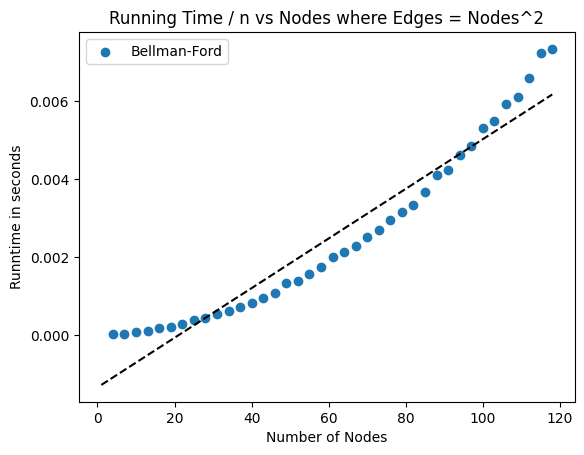

In [22]:
x = np.arange(number_of_increments)*3+1
plt.scatter(x[1:], (bellman_ford_times / (x))[1:], label = 'Bellman-Ford')
a, b = np.polyfit(x[1:], (bellman_ford_times / (x))[1:], 1)
plt.plot(x, a*x+b, 'k--')
plt.xlabel('Number of Nodes')
plt.ylabel('Runntime in seconds')
plt.title('Running Time / n vs Nodes where Edges = Nodes^2')
plt.legend()
plt.show()

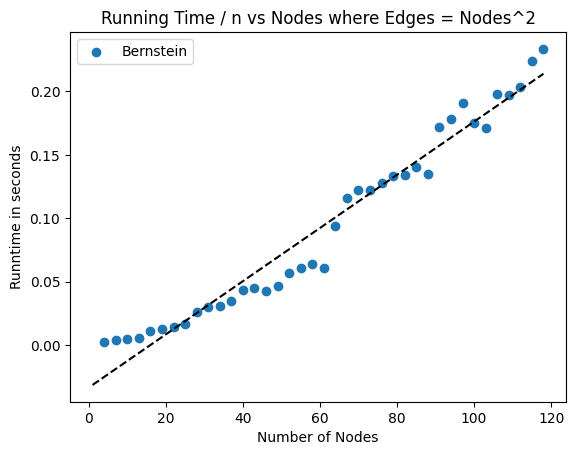

In [15]:
plt.scatter(x[1:], (bernstein_times / (x))[1:], label = 'Bernstein')
a, b = np.polyfit(x[1:], (bernstein_times / (x))[1:], 1)
plt.plot(x, a*x+b, 'k--')
plt.xlabel('Number of Nodes')
plt.ylabel('Runntime in seconds')
plt.title('Running Time / n vs Nodes where Edges = Nodes^2')
plt.legend()
plt.show()

In [32]:
df = pd.DataFrame({'runtime': x[1:],
                   'bernstien': (bernstein_times / (x))[1:],
                   'bellmanford': (bellman_ford_times / (x))[1:]
                   })

                            OLS Regression Results                            
Dep. Variable:            bellmanford   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     524.4
Date:                Tue, 02 May 2023   Prob (F-statistic):           1.90e-23
Time:                        14:37:47   Log-Likelihood:                 235.99
No. Observations:                  39   AIC:                            -468.0
Df Residuals:                      37   BIC:                            -464.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0013      0.000     -6.882      0.0

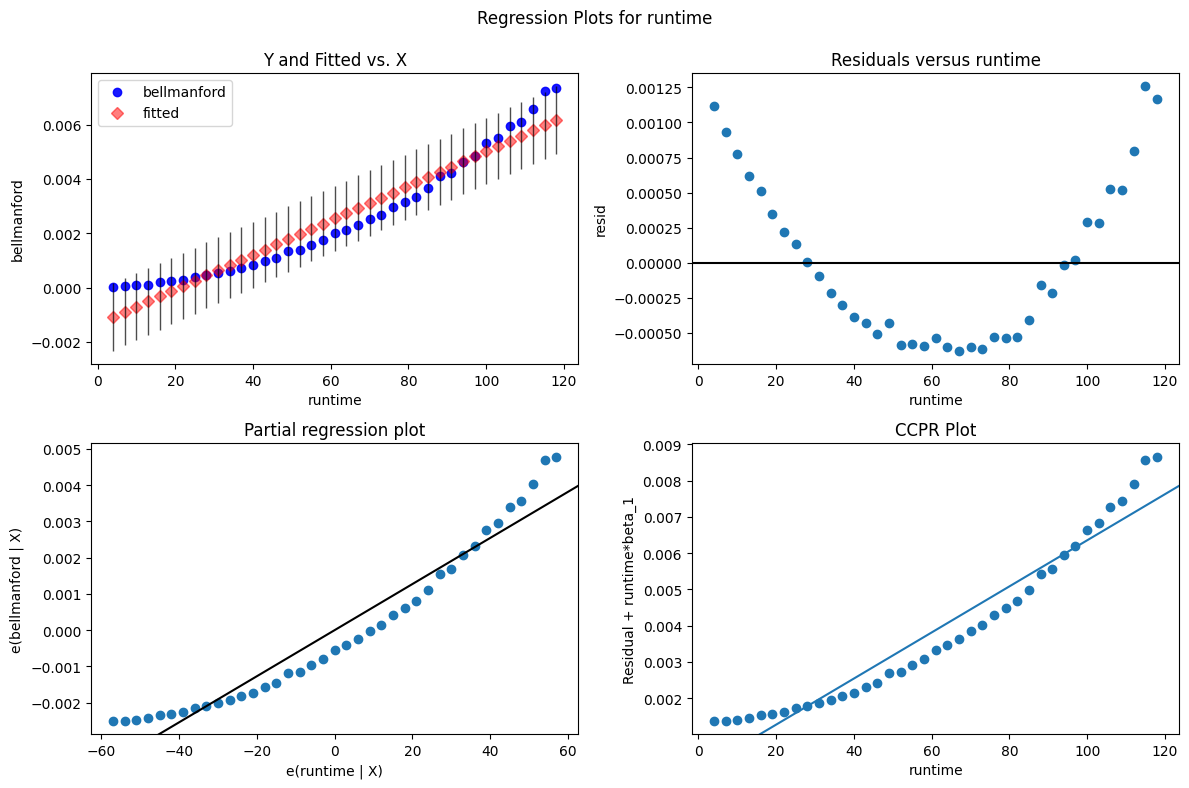

In [30]:
model = ols('bellmanford ~ runtime', data=df).fit()
print(model.summary())

#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'runtime', fig=fig)

                            OLS Regression Results                            
Dep. Variable:              bernstien   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1029.
Date:                Tue, 02 May 2023   Prob (F-statistic):           1.31e-28
Time:                        14:43:22   Log-Likelihood:                 114.40
No. Observations:                  39   AIC:                            -224.8
Df Residuals:                      37   BIC:                            -221.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0298      0.004     -6.809      0.0

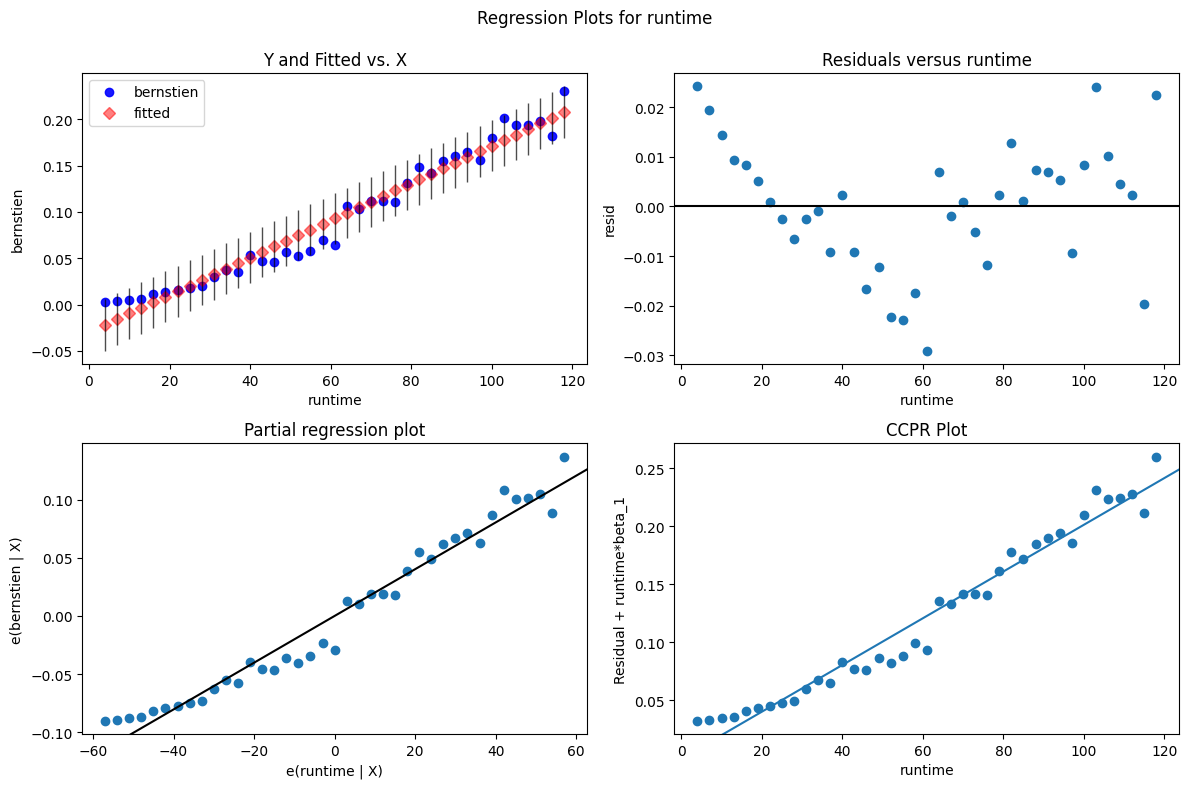

In [33]:
model = ols('bernstien ~ runtime', data=df).fit()
print(model.summary())

#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'runtime', fig=fig)